# Assignment2 - Supervised Learning flow

# Part 1 - Student details:

Bar 0962

## Part 2 - Initial Preparations 

### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

### Intializing the data:

In [2]:
train_df = pd.read_csv('diabetes_train.csv')
test_df = pd.read_csv('diabetes_test.csv')

### Printing 5 first rows of the loaded datasets:

In [3]:
train_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,52.0,1.0,23.0,107.00,179.0,123.7,42.5,4.21,4.1589,93.0,50.0
1,22.0,1.0,18.6,97.00,114.0,57.6,46.0,2.00,3.9512,83.0,101.0
2,34.0,2.0,25.3,111.00,230.0,162.0,39.0,6.00,4.9767,90.0,181.0
3,38.0,2.0,26.8,105.00,181.0,119.2,37.0,5.00,4.8203,91.0,107.0
4,55.0,1.0,23.0,94.67,190.0,137.6,38.0,5.00,4.2767,106.0,146.0


In [4]:
test_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,60.0,2.0,28.2,112.0,185.0,113.8,42.0,4.0,4.9836,93.0,178.0
1,55.0,2.0,22.9,81.0,123.0,67.2,41.0,3.0,4.3041,88.0,129.0
2,46.0,1.0,20.6,73.0,172.0,107.0,51.0,3.0,4.2485,80.0,53.0
3,58.0,1.0,22.8,91.0,196.0,118.8,48.0,4.0,4.9836,115.0,206.0
4,36.0,2.0,24.1,112.0,193.0,125.0,35.0,6.0,5.1059,95.0,163.0


### Exploratory data analysis:

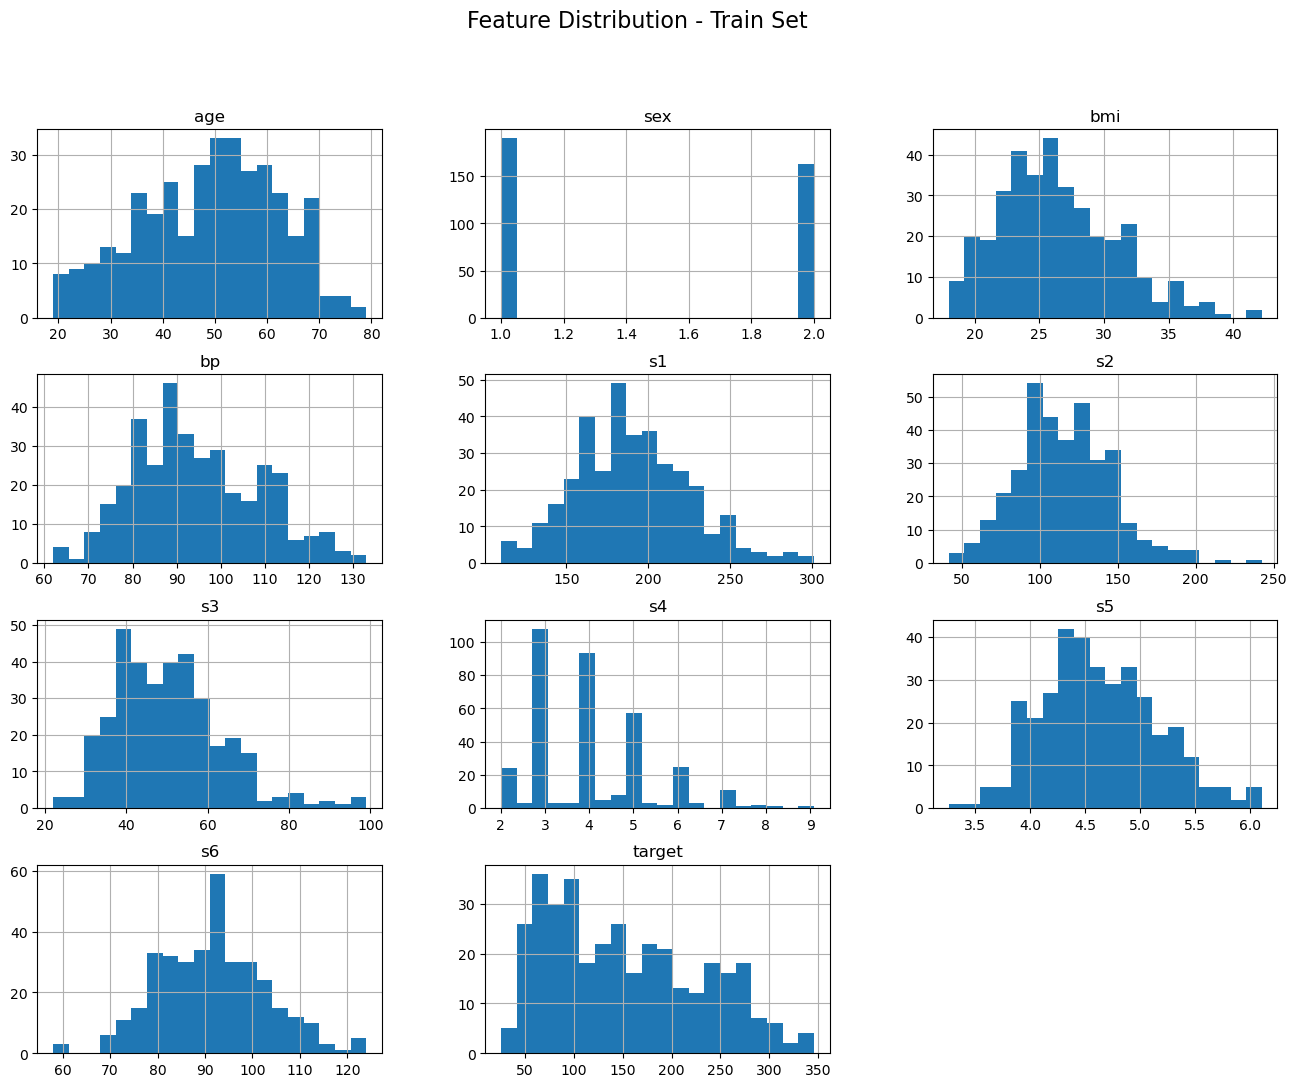

In [5]:
train_df.hist(figsize=(16, 12), bins=20)
plt.suptitle('Feature Distribution - Train Set', fontsize=16)
plt.show()

The BMI feature has a relatively normal distribution, with most values centered around the mean of approximately 26.4, indicating that the majority of patients have a BMI close to this average.

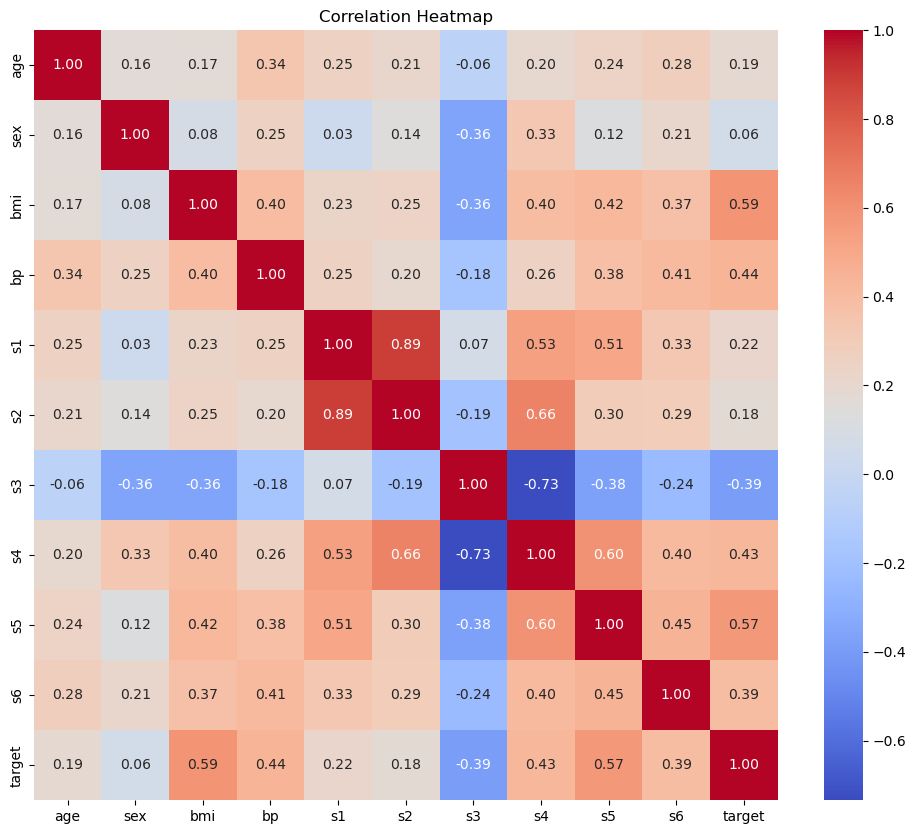

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The "s5" feature shows the highest positive correlation (0.57) with the target variable, suggesting it plays a significant role in predicting disease progression in this dataset.

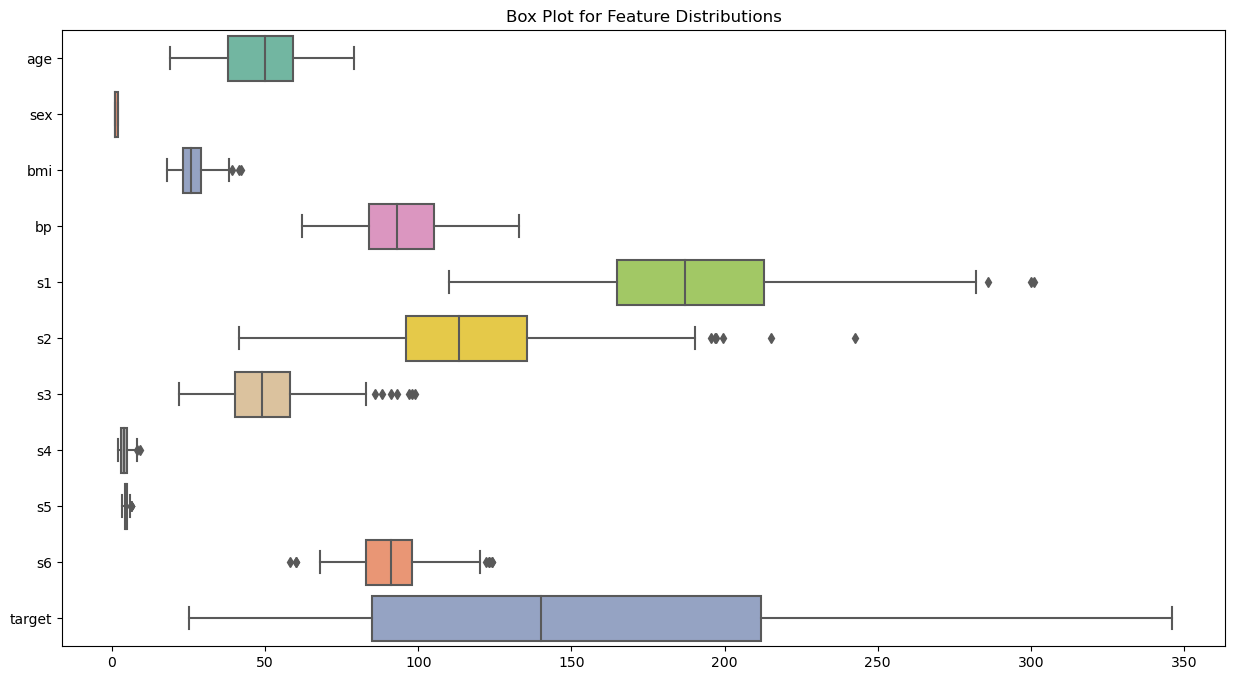

In [7]:
# Box Plot - to identify outliers in each feature
plt.figure(figsize=(15, 8))
sns.boxplot(data=train_df, orient="h", palette="Set2")
plt.title('Box Plot for Feature Distributions')
plt.show()

The "s1" and "s2" features exhibit multiple outliers, suggesting that some patients have exceptionally high or low serum measurement values.

### Using Simple Random Forest to discover feature importance: 

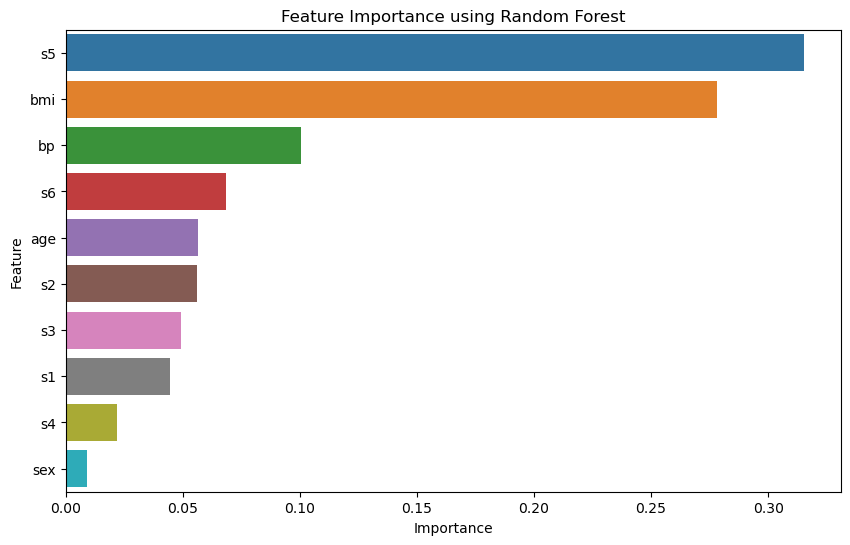

In [8]:
# Separating features and target
target_column = train_df.columns[-1]
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

# Train a simple Random Forest model to determine feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance using Random Forest')
plt.show()

The "s5" feature is the most influential predictor, with "bmi" being the second most important, suggesting they play key roles in predicting disease progression in this dataset.

## Part 3 - Experiments

### Capping outliers:

In [9]:
columns_with_outliers = ['s1', 's2']

# Define a function to calculate capping thresholds based on the training set
def calculate_capping_limits(df, column):
    lower_limit = df[column].quantile(0.01)
    upper_limit = df[column].quantile(0.99)
    return lower_limit, upper_limit

# Calculate and store capping limits for the training set
capping_limits = {}
for col in columns_with_outliers:
    lower, upper = calculate_capping_limits(train_df, col)
    capping_limits[col] = (lower, upper)

# Apply capping using these limits to the training set only
def cap_outliers_with_limits(df, column, lower_limit, upper_limit):
    df[column] = df[column].clip(lower_limit, upper_limit)

# Apply capping on the training set
for col in columns_with_outliers:
    cap_outliers_with_limits(train_df, col, capping_limits[col][0], capping_limits[col][1])

# Check the updated training data after capping (Optional: Print a summary)
print("Training data after capping outliers:")
print(train_df[columns_with_outliers].describe())


Training data after capping outliers:
               s1          s2
count  353.000000  353.000000
mean   189.910028  115.749337
std     34.299374   29.645279
min    117.560000   53.712000
25%    165.000000   96.000000
50%    187.000000  113.400000
75%    213.000000  135.600000
max    282.000000  196.992000


### Feature Scaling:

In [10]:
# Separating features and target for both train and test sets
target_column = 'target'  # Ensure this matches the actual target column name
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

# Initialize and fit the StandardScaler on training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaler to transform the test features
X_test_scaled = scaler.transform(X_test)

# Convert the scaled features back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


### 1. Polynomial Features:
Polynomial features capture non-linear relationships between features, which are essential since the relationship between certain features (e.g., "s5" and "bmi") and the target variable may not be linear.
We added polynomial terms up to the second degree.

In [11]:
# Create polynomial features for 's5' and 'bmi' in the training set
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled_df[['s5', 'bmi']])  # Using scaled features

# Extract feature names
poly_feature_names = poly.get_feature_names_out(['s5', 'bmi'])

# Convert the transformed training features to a DataFrame
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)

### 2. Log Transformation:
Log transformation helps normalize skewed features, reducing the impact of outliers. It was applied to features "s1" and "s2."

In [12]:
log_features = ['s1', 's2']

# Check for negative values or NaNs in the relevant features
print("Checking for negative values or NaNs in training and test sets:")
print(X_train_scaled_df[log_features].describe())

# Replace negative values and NaNs with a small positive value before log transformation
small_value = 1e-9
for feature in log_features:
    X_train_scaled_df[feature] = X_train_scaled_df[feature].clip(lower=small_value).fillna(small_value)
    
# Apply log transformation to the corrected training and test sets
X_train_log = X_train_scaled_df.copy()

for feature in log_features:
    X_train_log[feature + '_log'] = np.log1p(X_train_scaled_df[feature])

Checking for negative values or NaNs in training and test sets:
                 s1            s2
count  3.530000e+02  3.530000e+02
mean   7.384713e-16 -1.666907e-16
std    1.001419e+00  1.001419e+00
min   -2.112363e+00 -2.095625e+00
25%   -7.272840e-01 -6.671339e-01
50%   -8.496245e-02 -7.936076e-02
75%    6.741449e-01  6.705567e-01
max    2.688699e+00  2.744382e+00


### 3. Interaction Features:
Interaction terms capture the combined effects of features that might influence the target variable.
We created an interaction term between "s5" and "bmi."

In [13]:
# Create interaction features for both training and test sets
X_train_interaction = X_train_scaled_df.copy()

# Create the 's5_bmi_interaction' feature using the scaled values
X_train_interaction['s5_bmi_interaction'] = X_train_scaled_df['s5'] * X_train_scaled_df['bmi']

### Feature Engineering Combinations and Evaluation:

We evaluated five combinations using 5-fold cross-validation and compared their R² scores:
Basic Features: Only the scaled original features.
Basic + Polynomial: Combining the scaled features with polynomial features.
Basic + Log: Combining the scaled features with log-transformed features.
Basic + Interaction: Combining the scaled features with interaction features.
All Combinations: Combining all engineered features together.

In [14]:
# Function to evaluate model using cross-validation
def evaluate_model(X, y, model=RandomForestRegressor(random_state=42), cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return scores.mean()

# Combining all steps into different feature engineering combinations
X_comb1 = X_train_scaled_df.copy()  # Basic Features
X_comb2 = pd.concat([X_train_scaled_df, X_train_poly_df], axis=1)  # Basic + Polynomial
X_comb3 = X_train_log  # Basic + Log Transformed
X_comb4 = X_train_interaction  # Basic + Interaction
X_comb5 = pd.concat([X_comb2, X_train_log[[f + '_log' for f in log_features]], X_train_interaction[['s5_bmi_interaction']]], axis=1)  # All Combinations

# Evaluating each combination
score_comb1 = evaluate_model(X_comb1, y_train)
score_comb2 = evaluate_model(X_comb2, y_train)
score_comb3 = evaluate_model(X_comb3, y_train)
score_comb4 = evaluate_model(X_comb4, y_train)
score_comb5 = evaluate_model(X_comb5, y_train)

# Storing results in a DataFrame
feature_combination_results = pd.DataFrame({
    'Combination': ['Basic Features', 'Basic + Polynomial', 'Basic + Log', 'Basic + Interaction', 'All Combinations'],
    'R2 Score': [score_comb1, score_comb2, score_comb3, score_comb4, score_comb5]
})

# Display the results
print(feature_combination_results)

           Combination  R2 Score
0       Basic Features  0.445955
1   Basic + Polynomial  0.437132
2          Basic + Log  0.443680
3  Basic + Interaction  0.434078
4     All Combinations  0.434221


The results indicated that the "Basic" combination was the best, achieving the highest R² score.

In [15]:
# Using the best feature combination from previous steps (Basic)
X = X_comb1  # Basic features from previous results
y = y_train

# Initialize different regression models (excluding XGBoost)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Function to evaluate model performance using R2 score
def evaluate_model_r2(model, X, y, cv=5):
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return np.mean(r2_scores)

# Evaluate all models using R2 score
model_r2_scores = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    model_r2_scores[name] = evaluate_model_r2(model, X, y)

# Convert the results into a DataFrame for comparison
model_r2_df = pd.DataFrame.from_dict(model_r2_scores, orient='index', columns=['R2 Score'])
model_r2_df = model_r2_df.sort_values(by='R2 Score', ascending=False)

# Display the R2 scores for all models
print("\nModel R2 Score Comparison:")
print(model_r2_df)

# Identify and display the best model based on R2 score
best_model_name = model_r2_df.idxmax()['R2 Score']
best_model_r2 = model_r2_df.loc[best_model_name]
print(f"\nThe best model is {best_model_name} with an R2 score of {best_model_r2['R2 Score']:.4f}")


Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Support Vector Regressor...

Model R2 Score Comparison:
                          R2 Score
Lasso Regression          0.486476
Ridge Regression          0.486445
Linear Regression         0.486133
Random Forest             0.445955
Gradient Boosting         0.384429
Support Vector Regressor  0.146065
Decision Tree            -0.159138

The best model is Lasso Regression with an R2 score of 0.4865


In [18]:
# Define the parameter grid for Lasso Regression
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'max_iter': [1000, 2000, 5000]           # Maximum number of iterations
}

# Initialize the Lasso Regressor
lasso = Lasso(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters for Lasso: {best_params}")
print(f"Best R2 Score after Tuning with Lasso: {best_score:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Hyperparameters for Lasso: {'alpha': 1, 'max_iter': 1000}
Best R2 Score after Tuning with Lasso: 0.4865


## Part 4 - Training 

In [19]:
# Initialize the Lasso model with the best hyperparameters obtained from GridSearchCV
lasso_model = Lasso(**grid_search.best_params_)

# Fit the model on the entire training data
lasso_model.fit(X, y)

print("Model training is complete with the best hyperparameters (Lasso).")

Model training is complete with the best hyperparameters (Lasso).


## Part 5 - Apply on test and show model performance estimation

R² Score on Test Set with Lasso: 0.4697


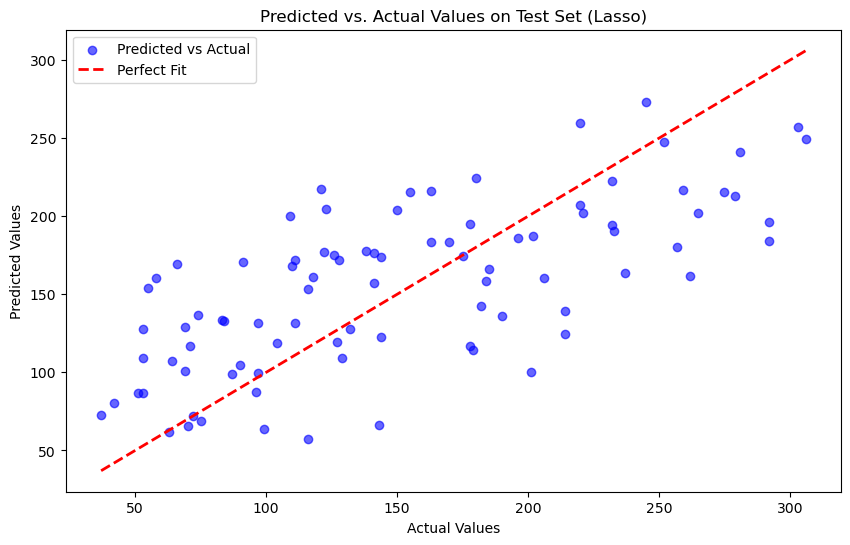

In [20]:
# Use the trained Lasso model to make predictions on the test set
y_pred_test = lasso_model.predict(X_test_scaled_df)

# Evaluate model performance on the test set
test_r2_score = r2_score(y_test, y_pred_test)
print(f"R² Score on Test Set with Lasso: {test_r2_score:.4f}")

# Visualize the predicted vs actual values to assess the model's performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Perfect Fit')
plt.title('Predicted vs. Actual Values on Test Set (Lasso)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
